In [ ]:
!tensorboard --logdir=runs

In [35]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np

writer = SummaryWriter()

for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [78]:
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import torchvision
import gc
from tqdm import tqdm_notebook
import math
import imgaug
#import imageio
#from matplotlib.patches import Rectangle
#from imgaug import augmenters as iaa 
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [3]:
class config():
    DATA_PATH = os.path.join('','data', 'global-wheat-detection')
    BATH_SIZE = 8
    STEP_SIZE=5
    CHECK_POINT_STEPS = 100
    DEVICE = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
    SPLIT = 0.8
    AUG = None
conf = config()

In [166]:
ia.seed(1)
aug_seq = iaa.Sequential([
    iaa.flip.Fliplr(p=0.5),
    iaa.flip.Flipud(p=0.5), 
    iaa.Rot90([0,1,2,3]),
    iaa.Sometimes(.5,iaa.WithBrightnessChannels(iaa.Add((-50, 50)))),#])
    iaa.Sometimes(.5, iaa.size.Crop(keep_size=False))])
conf.AUG = aug_seq

In [178]:
class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, config, train=True, augmentation=True, random_seed=0):       # transforms,
        
        self.CONFIG=config
        self.TRAIN_DF = pd.read_csv(os.path.join(self.CONFIG.DATA_PATH, 'train.csv'))
        self.END_IDX = int(len(os.listdir(os.path.join(self.CONFIG.DATA_PATH, 'train')))*self.CONFIG.SPLIT)
        self.AUGMENT = augmentation
        if train==True:  
            self.IMGS = [img.split('.')[0] for img in os.listdir(os.path.join(self.CONFIG.DATA_PATH, 'train'))[:self.END_IDX]]
        else:
            self.IMGS = [img.split('.')[0] for img in os.listdir(os.path.join(self.CONFIG.DATA_PATH, 'train'))[self.END_IDX:]]
        np.random.seed(random_seed)
        
    def parse_bbox_string(self, bbox_string):
        parsed_string = bbox_string.strip('[').strip(']').split(', ')
        parsed_values = list(map(float, parsed_string))
        parsed_values[2]+=parsed_values[0]
        parsed_values[3]+=parsed_values[1]
        return np.array(parsed_values, dtype=np.float32)
    
    def augment_img(self, img, boxes):  # Boxes = (x1, y1, x2, y2), img = channel last (W, H, C)
        b_boxes = BoundingBoxesOnImage([BoundingBox(x1=b[0], x2=b[2], y1=b[1], y2=b[3]) for b in boxes], shape=img.shape)
        img, aug_boxes = self.CONFIG.AUG(image=img, bounding_boxes=b_boxes)
        aug_boxes = aug_boxes.remove_out_of_image_fraction(.6)
        if len(aug_boxes)>0:
            aug_boxes = np.array(([list(b[0])+list(b[1]) for b in aug_boxes]), dtype=np.float32)
        else:
            aug_boxes = np.array([], dtype=np.float32)
        return img, aug_boxes
        
    
    def __getitem__(self, idx):
        img_path =  os.path.join(conf.DATA_PATH, 'train', self.IMGS[idx]+'.jpg')
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        
        bbox_strings = self.TRAIN_DF[self.TRAIN_DF.image_id==self.IMGS[idx]].bbox
        
        if len(bbox_strings)>0:
            boxes = np.array([self.parse_bbox_string(bbox_string) for bbox_string in bbox_strings], dtype=np.float32)
            
            if self.AUGMENT:
                img, boxes = self.augment_img(img, boxes)
                labels = np.array([1]*len(boxes), dtype=np.int64)
        else:
            boxes = np.array([], dtype=np.float32)
            labels = np.array([], dtype=np.int64)
        
        
        img = np.array(np.moveaxis(img, -1, 0), dtype=np.float32)/255
        return img, {'boxes':boxes, 'labels':labels}

    def __len__(self):
        return len(self.IMGS)
def collate_fn(batch):
    return tuple(zip(*batch))

def plot_boxes(image, boxes, color):
    plt.imshow(image)
    for box in boxes:
        rect = Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor=color,facecolor='none')
        plt.axes().add_patch(rect)
    plt.show()

In [179]:
WD_Train = WheatDataset(conf)
WD_Valid = WheatDataset(conf, train=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


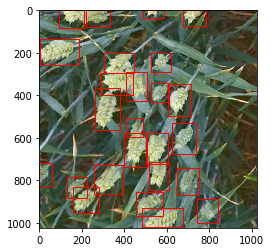

In [182]:
plot_boxes(np.moveaxis(i, 0, -1), t['boxes'], 'r')

In [34]:
torch.random.manual_seed(5)
WD_Train_Loader = torch.utils.data.DataLoader(WD_Train, batch_size=conf.BATH_SIZE, shuffle=True, collate_fn=collate_fn)
WD_Valid_Loader = torch.utils.data.DataLoader(WD_Valid, batch_size=conf.BATH_SIZE, shuffle=True, collate_fn=collate_fn)

In [6]:
EPOCH = 0
__step=0

In [8]:
M = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=2, pretrained_backbone=True)
M.to(conf.DEVICE)

params = [p for p in M.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)



for images, targets in tqdm_notebook(WD_Loader):
    print(len(images), images[0].shape)
    
    images = [torch.tensor(image, dtype = torch.float32).to(conf.DEVICE) for image in images]
    targets = [{k: torch.tensor(v).to(conf.DEVICE) for k, v in target.items()} for target in targets]
    
    loss_dictionary = M(images,targets)
    summed_loss = sum(loss for loss in loss_dictionary.values())
    summed_loss_value = summed_loss.item()
    
    
    if __step%conf.STEP_SIZE==0:
        loss_str=''
        for loss_type, value in loss_dictionary.items():
            loss_str+=str(loss_type)+': '+str(round(value.item(),6))+'   '
        print(loss_str)
        print('step: ',__step ,'    Total Loss: ', summed_loss_value )
        
        
    
    if math.isfinite(summed_loss_value):
        optimizer.zero_grad()
        summed_loss.backward()
        optimizer.step()
        
    else:
        print('Loss is undefined:',summed_loss_value,'   skipping BackProp for step no:', __step)
        print(loss_dictionary)
        
        
    
    if __step%conf.CHECK_POINT_STEPS==0:
        print('')
        print('====================================================================================================')
        print('')
        torch.save(M, 'model/global_wheat_epoch_'+str(EPOCH)+'_step_'+str(__step)+'_loss_'+str(summed_loss_value)+'.model')
        print('model saved at step:', __step)
        torch.cuda.empty_cache()
        gc.collect()
        print('cuda cache cleared')
        print('')
        print('====================================================================================================')
        print('')
        
        
        
    
        
    __step+=1
print('')
print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
print('')
torch.save(M, 'model/global_wheat_epoch_'+str(EPOCH)+'_loss_'+str(summed_loss_value)+'.model')
print('model saved after Epoch', EPOCH)
torch.cuda.empty_cache()
gc.collect()
print('cuda cache cleared')
print('')
print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
print('')

8 (3, 1024, 1024)


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


loss_classifier: 0.698951   loss_box_reg: 0.140154   loss_objectness: 0.693019   loss_rpn_box_reg: 0.260049   
step:  0     Total Loss:  1.792172908782959


model saved at step: 0
cuda cache cleared


8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
loss_classifier: 0.580664   loss_box_reg: 0.177093   loss_objectness: 0.690315   loss_rpn_box_reg: 0.214994   
step:  5     Total Loss:  1.6630659103393555
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
loss_classifier: 0.585652   loss_box_reg: 0.371748   loss_objectness: 0.682226   loss_rpn_box_reg: 0.241882   
step:  10     Total Loss:  1.8815083503723145
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
loss_classifier: 0.435645   loss_box_reg: 0.208578   loss_objectness: 0.677104   loss_rpn_box_reg: 0.361739   
step:  15     Total Loss:  1.6830660104751587
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3,

loss_classifier: 0.26855   loss_box_reg: 0.235992   loss_objectness: 0.108573   loss_rpn_box_reg: 0.180975   
step:  310     Total Loss:  0.7940903902053833
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
loss_classifier: 0.289638   loss_box_reg: 0.30029   loss_objectness: 0.113487   loss_rpn_box_reg: 0.162231   
step:  315     Total Loss:  0.8656449317932129
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
loss_classifier: 0.273743   loss_box_reg: 0.250097   loss_objectness: 0.092748   loss_rpn_box_reg: 0.164896   
step:  320     Total Loss:  0.7814842462539673
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
loss_classifier: 0.302043   loss_box_reg: 0.305425   loss_objectness: 0.120113   loss_rpn_box_reg: 0.193134   
step:  325     Total Loss:  0.92071533203125
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
8 (3, 1024, 1024)
loss_classif